# Object Detection with PyTorch

This workshop demonstrates how to build a simple object detection system using PyTorch that can:
- Detect a single object in an image
- Classify the object type (circle or rectangle)
- Locate the object's position (x, y coordinates)

```
Praisan Padungweang

2024, College of Computing, KKU
```

## Common Issues and Tips

1. **Data Normalization**:
   - All position and size values are normalized to [0,1]
   - Must denormalize for visualization
   - Helps with training stability

2. **Model Capacity**:
   - Current architecture is intentionally simple
   - Can be extended with more layers for complex scenes

3. **Performance Metrics**:
   - MSE loss combines classification and regression
   - Consider separate metrics for position vs. classification accuracy

## Prepare Dataset
- Create custom dataset class for handle coco format annotation from label studio.

In [1]:
# Dowload the dataset and unzip it
!gdown 1sVTk0Wnrkoq-FN1USoMdfEJFI6LxYfHi

Downloading...
From: https://drive.google.com/uc?id=1sVTk0Wnrkoq-FN1USoMdfEJFI6LxYfHi
To: /content/dataset_simpleDetection.zip
100% 36.6k/36.6k [00:00<00:00, 61.2MB/s]


In [2]:
!unzip /content/dataset_simpleDetection

Archive:  /content/dataset_simpleDetection.zip
replace train/images/055cf90b-image_87.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train/images/055cf90b-image_87.png  
replace train/images/06fd5261-image_68.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: train/images/06fd5261-image_68.png  
  inflating: train/images/08c92a46-image_36.png  
  inflating: train/images/0c392bac-image_76.png  
  inflating: train/images/0d193863-image_71.png  
  inflating: train/images/10758b91-image_92.png  
  inflating: train/images/12883919-image_79.png  
  inflating: train/images/15e6e73d-image_88.png  
  inflating: train/images/20a82ac5-image_69.png  
  inflating: train/images/21eba3dd-image_46.png  
  inflating: train/images/23127e28-image_31.png  
  inflating: train/images/313b0477-image_97.png  
  inflating: train/images/348d4481-image_83.png  
  inflating: train/images/3eb430e4-image_66.png  
  inflating: train/images/43e7968b-image_70.png  
  inflating: train/images/45e751cb-

In [3]:
import os
import json
import random
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torch
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

In [4]:
# Create dataset class for handle coco annoation format

class SyntheticDectectionDataset(Dataset):
    def __init__(self, images_path, annotations_file, transform=None):
        self.images_path = images_path
        self.coco = COCO(annotations_file)
        self.transform = transform
        self.image_ids = list(self.coco.imgs.keys())

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.imgs[image_id]
        image_path = os.path.join(self.images_path, image_info['file_name']).replace("\\", '/')
        image = Image.open(image_path).convert('L')
        image = np.array(image, dtype=np.float32) / 255.

        #load annotations
        anns_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(anns_ids)

        #prepare bbox and label
        bboxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]

        #notmalize bbox [x,y,w,h]
        bboxes = np.array(bboxes, dtype=np.float32)
        bboxes[:, 0] /= image_info['width']
        bboxes[:, 1] /= image_info['height']
        bboxes[:, 2] /= image_info['width']
        bboxes[:, 3] /= image_info['height']

        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        #create target dictionary
        target = {'bboxes': bboxes,
                  'labels': labels}

        if self.transform:
            image = self.transform(image)

        return image, target

In [5]:
# Set paths
train_dir = "/content/train"
test_dir = "/content/test"
val_dir = "/content/val"

train_anns = "/content/train.json"
test_anns = "/content/test.json"
val_anns = "/content/val.json"

train_transform = transforms.Compose([
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()])

val_transform = transforms.Compose([
    transforms.ToTensor()])

In [6]:
# Create datasets
train_dataset = SyntheticDectectionDataset(train_dir, train_anns, transform=train_transform)


# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


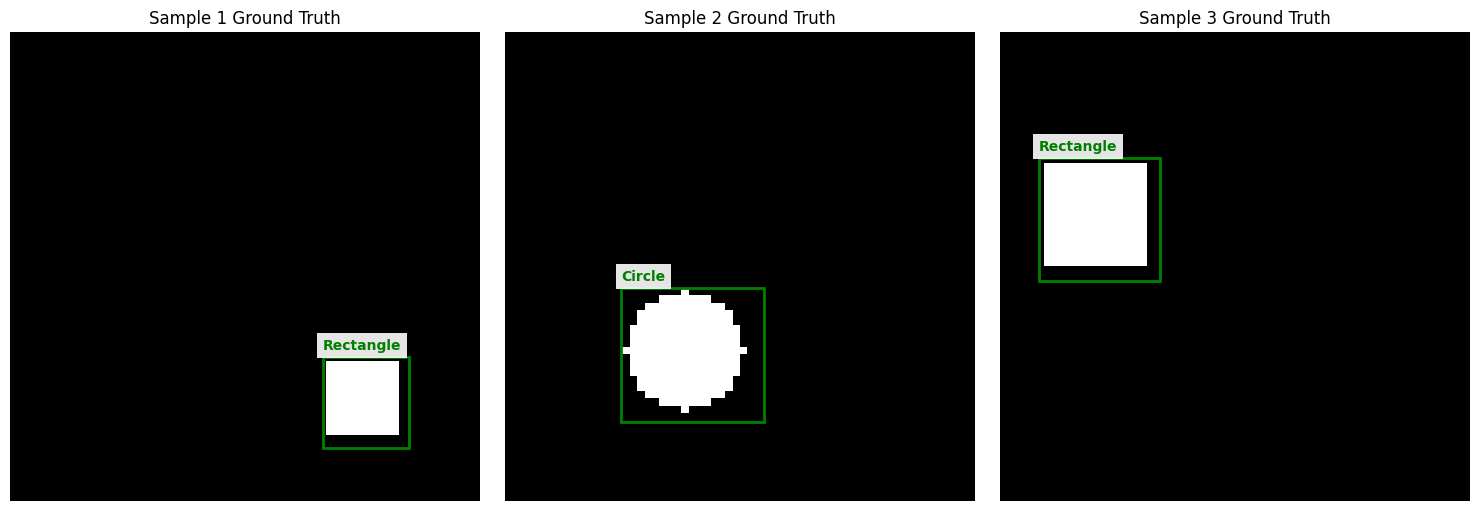

In [7]:
def plot_samples_from_dataloader(dataloader, num_samples=1):
    images, targets = next(iter(dataloader))
    num_samples = min(num_samples, len(images))

    # Create a grid for plotting
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    # Ensure `axes` is iterable when there's only one sample
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        image = images[i].numpy().squeeze()  # Convert to numpy and remove the channel dimension
        gt_bboxes = targets['bboxes'][i].numpy()  # Ground truth bounding boxes for this image
        labels = targets['labels'][i].numpy()  # Ground truth labels for this image

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Sample {i + 1} Ground Truth")

        # Plot the bounding boxes
        for bbox, label in zip(gt_bboxes, labels):
            # Denormalize the bounding box to pixel coordinates
            x, y, w, h = bbox *64
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            axes[i].add_patch(rect)

            # Add label above the bounding box
            label_text = "Circle" if label == 0 else "Rectangle"
            axes[i].text(x, y - 1, label_text, color='g', fontsize=10, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_samples_from_dataloader(train_loader, num_samples=3)

## Model Architecture
The CNN architecture consists of:

1. **Convolutional Layers**:
   - First conv layer: 1→32 channels, 3x3 kernel
   - Second conv layer: 32→64 channels, 3x3 kernel
   - Each followed by ReLU activation and 2x2 max pooling

2. **Fully Connected Layers**:
   - First FC layer: 64×16×16 → 128 neurons
   - Output layer: 128 → 5 outputs (class, x, y, w, h)

Input image processing:
- Input: 64×64×1 (grayscale)
- After conv1+pool: 32×32×32
- After conv2+pool: 16×16×64
- Flattened: 16,384 features
- Final output: 5 values

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# Create a CNN model for object detection

class SimpleObjectDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 70)
        self.fc3 = nn.Linear(70, 128)
        self.fc4 = nn.Linear(128, 5) #output (class, x, y, w, h)

    def forward(self, x):
        # conv
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        #dense
        x = nn.Flatten()(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [ ]:
!pip install torchview

In [10]:
from torchview import draw_graph
from torchsummary import summary

In [11]:
# prompt: use summary

model = SimpleObjectDetector().to(device)
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             320
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Linear-7                  [-1, 128]       1,048,704
            Linear-8                   [-1, 70]           9,030
            Linear-9                  [-1, 128]           9,088
           Linear-10                    [-1, 5]             645
Total params: 1,160,139
Trainable params: 1,160,139
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 2.19
Params size (MB): 4.43
Estimat

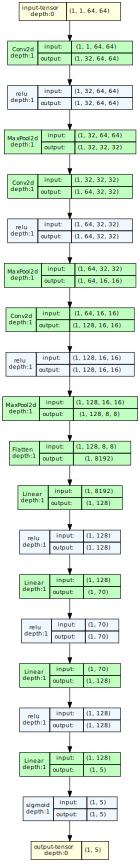

In [12]:
draw_graph(model, input_size=(1, 1, 64, 64)).visual_graph

## Model Training

The training setup uses:
- Loss function: Mean Squared Error (MSE)
- Optimizer: Adam

The loss function combines:
- Classification error for shape type
- Regression error for position and size

In [13]:
train_dataset = SyntheticDectectionDataset(train_dir, train_anns, transform=train_transform)
test_dataset = SyntheticDectectionDataset(test_dir, test_anns, transform=test_transform)
val_dataset = SyntheticDectectionDataset(val_dir, val_anns, transform=val_transform)



train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [14]:
# Create train function with collect loss history

def train_model(model, dataloaders, criterion, optimizer, num_epochs, weights_name='weight_save.pth'):
    model.to(device)
    history = {"train_loss" :[],
               "val_loss" : []}
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('--' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            data_loader = dataloaders[phase]

            with tqdm(total =len(data_loader), desc=f"{phase.capitalize()} Epoch {epoch+1}") as pbar:
                 for images, targets in data_loader:
                    images = images.to(device)
                    targets = {k:v.to(device) for k,v in targets.items()}

                    #combine bbox and label
                    target_bboxes = targets['bboxes'].view(-1,4) #(n,4)
                    target_classes = targets['labels'].view(-1,1) #(n,1)
                    target_labels = torch.cat((target_classes, target_bboxes), dim=1) # (n,5)

                    if phase == 'train':
                        optimizer.zero_grad()

                    #forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(images)
                        loss = criterion(outputs, target_labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    #update loss
                    running_loss += loss.item() * images.size(0)
                    pbar.update(1)

            #calculate avg for epoch loss
            epoch_loss = running_loss / len(data_loader.dataset)
            history[f"{phase}_loss"].append(epoch_loss)

            print(f"{phase} Loss: {epoch_loss:.4f}")

            #save best weight
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                torch.save(model.state_dict(), weights_name)
                print('Save best weight')

    #load best weight
    model.load_state_dict(torch.load(weights_name))

    return model, history

In [15]:
# Create test function for predict test_loader

def test_model(model, test_loader):
    model.eval()
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(device)
            targets = {k:v.to(device) for k,v in targets.items()}
            target_bboxes = targets['bboxes'].view(-1,4) #(n,4)
            target_classes = targets['labels'].view(-1,1) #(n,1)
            target_labels = torch.cat((target_classes, target_bboxes), dim=1) # (n,5)
            ground_truths.extend(target_labels.cpu().numpy().tolist())
            outputs = model(images.unsqueeze(0))
            predictions.extend(outputs.cpu().numpy().tolist())

    return predictions, ground_truths

In [16]:
# Set dataloader
dataloaders = {'train': train_loader, 'val': val_loader}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training setting
model = SimpleObjectDetector()
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25

In [17]:
# Training Model
best_model, train_history = train_model(model, dataloaders, criterion, optimizer, epochs, 'SimpleObjectDetector.pth')

Epoch 1/25
--------------------


Train Epoch 1: 100%|██████████| 5/5 [00:00<00:00, 11.75it/s]


train Loss: 0.0910


Val Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 23.31it/s]


val Loss: 0.0735
Save best weight
Epoch 2/25
--------------------


Train Epoch 2: 100%|██████████| 5/5 [00:00<00:00, 66.08it/s]


train Loss: 0.0718


Val Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 45.52it/s]


val Loss: 0.0702
Save best weight
Epoch 3/25
--------------------


Train Epoch 3: 100%|██████████| 5/5 [00:00<00:00, 28.02it/s]


train Loss: 0.0649


Val Epoch 3: 100%|██████████| 1/1 [00:00<00:00, 40.43it/s]


val Loss: 0.0697
Save best weight
Epoch 4/25
--------------------


Train Epoch 4: 100%|██████████| 5/5 [00:00<00:00, 60.93it/s]


train Loss: 0.0640


Val Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 44.32it/s]


val Loss: 0.0659
Save best weight
Epoch 5/25
--------------------


Train Epoch 5: 100%|██████████| 5/5 [00:00<00:00, 68.52it/s]


train Loss: 0.0608


Val Epoch 5: 100%|██████████| 1/1 [00:00<00:00, 98.68it/s]


val Loss: 0.0599
Save best weight
Epoch 6/25
--------------------


Train Epoch 6: 100%|██████████| 5/5 [00:00<00:00, 56.36it/s]


train Loss: 0.0545


Val Epoch 6: 100%|██████████| 1/1 [00:00<00:00, 65.09it/s]


val Loss: 0.0555
Save best weight
Epoch 7/25
--------------------


Train Epoch 7: 100%|██████████| 5/5 [00:00<00:00, 61.65it/s]


train Loss: 0.0502


Val Epoch 7: 100%|██████████| 1/1 [00:00<00:00, 85.26it/s]


val Loss: 0.0486
Save best weight
Epoch 8/25
--------------------


Train Epoch 8: 100%|██████████| 5/5 [00:00<00:00, 81.36it/s]


train Loss: 0.0486


Val Epoch 8: 100%|██████████| 1/1 [00:00<00:00, 104.66it/s]


val Loss: 0.0473
Save best weight
Epoch 9/25
--------------------


Train Epoch 9: 100%|██████████| 5/5 [00:00<00:00, 64.39it/s]


train Loss: 0.0468


Val Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 85.78it/s]


val Loss: 0.0474
Epoch 10/25
--------------------


Train Epoch 10: 100%|██████████| 5/5 [00:00<00:00, 39.39it/s]


train Loss: 0.0443


Val Epoch 10: 100%|██████████| 1/1 [00:00<00:00, 76.11it/s]


val Loss: 0.0482
Epoch 11/25
--------------------


Train Epoch 11: 100%|██████████| 5/5 [00:00<00:00, 51.37it/s]


train Loss: 0.0423


Val Epoch 11: 100%|██████████| 1/1 [00:00<00:00, 98.41it/s]


val Loss: 0.0483
Epoch 12/25
--------------------


Train Epoch 12: 100%|██████████| 5/5 [00:00<00:00, 55.95it/s]


train Loss: 0.0403


Val Epoch 12: 100%|██████████| 1/1 [00:00<00:00, 51.71it/s]


val Loss: 0.0431
Save best weight
Epoch 13/25
--------------------


Train Epoch 13: 100%|██████████| 5/5 [00:00<00:00, 25.13it/s]


train Loss: 0.0380


Val Epoch 13: 100%|██████████| 1/1 [00:00<00:00, 31.33it/s]


val Loss: 0.0408
Save best weight
Epoch 14/25
--------------------


Train Epoch 14: 100%|██████████| 5/5 [00:00<00:00, 57.52it/s]


train Loss: 0.0368


Val Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 75.65it/s]


val Loss: 0.0325
Save best weight
Epoch 15/25
--------------------


Train Epoch 15: 100%|██████████| 5/5 [00:00<00:00, 49.63it/s]


train Loss: 0.0338


Val Epoch 15: 100%|██████████| 1/1 [00:00<00:00, 86.43it/s]


val Loss: 0.0275
Save best weight
Epoch 16/25
--------------------


Train Epoch 16: 100%|██████████| 5/5 [00:00<00:00, 78.65it/s]


train Loss: 0.0328


Val Epoch 16: 100%|██████████| 1/1 [00:00<00:00, 105.21it/s]


val Loss: 0.0276
Epoch 17/25
--------------------


Train Epoch 17: 100%|██████████| 5/5 [00:00<00:00, 72.17it/s]


train Loss: 0.0322


Val Epoch 17: 100%|██████████| 1/1 [00:00<00:00, 46.14it/s]


val Loss: 0.0269
Save best weight
Epoch 18/25
--------------------


Train Epoch 18: 100%|██████████| 5/5 [00:00<00:00, 54.73it/s]


train Loss: 0.0308


Val Epoch 18: 100%|██████████| 1/1 [00:00<00:00, 43.31it/s]


val Loss: 0.0241
Save best weight
Epoch 19/25
--------------------


Train Epoch 19: 100%|██████████| 5/5 [00:00<00:00, 73.96it/s]


train Loss: 0.0284


Val Epoch 19: 100%|██████████| 1/1 [00:00<00:00, 75.24it/s]


val Loss: 0.0201
Save best weight
Epoch 20/25
--------------------


Train Epoch 20: 100%|██████████| 5/5 [00:00<00:00, 38.93it/s]


train Loss: 0.0263


Val Epoch 20: 100%|██████████| 1/1 [00:00<00:00, 84.00it/s]


val Loss: 0.0199
Save best weight
Epoch 21/25
--------------------


Train Epoch 21: 100%|██████████| 5/5 [00:00<00:00, 79.37it/s]


train Loss: 0.0247


Val Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 88.83it/s]


val Loss: 0.0236
Epoch 22/25
--------------------


Train Epoch 22: 100%|██████████| 5/5 [00:00<00:00, 74.54it/s]


train Loss: 0.0209


Val Epoch 22: 100%|██████████| 1/1 [00:00<00:00, 91.93it/s]


val Loss: 0.0229
Epoch 23/25
--------------------


Train Epoch 23: 100%|██████████| 5/5 [00:00<00:00, 76.02it/s]


train Loss: 0.0205


Val Epoch 23: 100%|██████████| 1/1 [00:00<00:00, 95.65it/s]


val Loss: 0.0241
Epoch 24/25
--------------------


Train Epoch 24: 100%|██████████| 5/5 [00:00<00:00, 83.27it/s]


train Loss: 0.0207


Val Epoch 24: 100%|██████████| 1/1 [00:00<00:00, 56.72it/s]


val Loss: 0.0267
Epoch 25/25
--------------------


Train Epoch 25: 100%|██████████| 5/5 [00:00<00:00, 18.93it/s]


train Loss: 0.0184


Val Epoch 25: 100%|██████████| 1/1 [00:00<00:00, 29.19it/s]

val Loss: 0.0210



<ipython-input-14-623062f9eba1>:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_name))


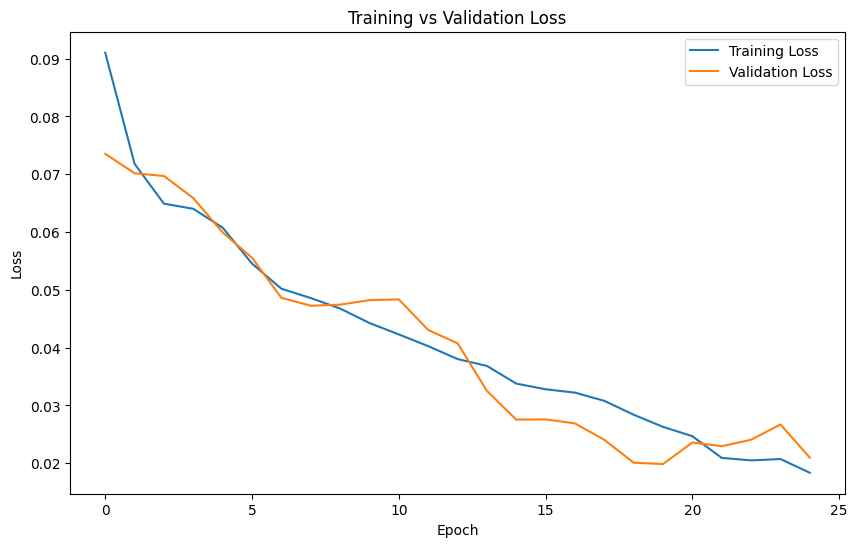

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(train_history['train_loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')

plt.legend()
plt.show()

## Model Evaluation
- Calculate the model performance using IoU, Precision, Recall and F1-Score

In [48]:
# IoU function to compute intersection over union
def compute_iou(pred_bbox, gt_bbox):
    x1 = max(pred_bbox[0], gt_bbox[0])
    y1 = max(pred_bbox[1], gt_bbox[1])
    x2 = min(pred_bbox[2], gt_bbox[2])
    y2 = min(pred_bbox[3], gt_bbox[3])
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    pred_area = (pred_bbox[2] - pred_bbox[0] + 1) * (pred_bbox[3] - pred_bbox[1] + 1)
    gt_area = (gt_bbox[2] - gt_bbox[0] + 1) * (gt_bbox[3] - gt_bbox[1] + 1)
    union = pred_area + gt_area - intersection
    iou = intersection / union

    return iou


def calculate_performance(predictions, ground_truths, iou_threshold=0.5):
    iou = 0
    pred_classes = []
    gt_classes = []
    count = 0
    for pred, gt in zip(predictions, ground_truths):
        pred_bboxes, pred_class = pred[1:], [1 if pred[0] >= 0.5 else 0]
        gt_bboxes, gt_class = gt[1:], [int(gt[0])]
        iou += compute_iou(pred_bboxes, gt_bboxes)
        pred_classes.extend(pred_class)
        gt_classes.extend(gt_class)

    mean_iou = iou / len(predictions)
    print(gt_classes, pred_classes, sep ='\n')
    precision, recall, f1_score, _ = precision_recall_fscore_support(gt_classes, pred_classes, average='weighted')
    return precision, recall, f1_score, mean_iou

In [49]:
predictions, ground_truths = test_model(model, test_dataset)

precision, recall, f1_score, mean_iou = calculate_performance(predictions, ground_truths)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"Mean IoU: {mean_iou:.4f}")

[0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0]
Precision: 0.7333
Recall: 0.7333
F1-Score: 0.7333
Mean IoU: 0.7582


## Visualization Outcome
- Visualize the model's predictions by comparing the bounding boxes of the ground truth labels and the model's predictions. Display the images with both sets of bounding boxes overlaid and analyze the performance.

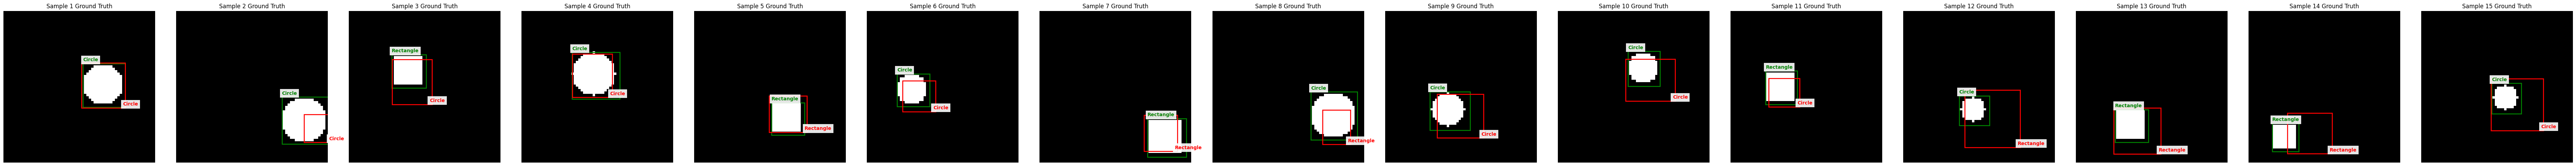

In [56]:
def plot_outcome_from_dataloader(dataloader, num_samples=1):
    model.eval()
    images, targets = next(iter(dataloader))
    num_samples = min(num_samples, len(images))

    # Create a grid for plotting
    fig, axes = plt.subplots(1, num_samples, figsize=(5 * num_samples, 5))
    # Ensure `axes` is iterable when there's only one sample
    if num_samples == 1:
        axes = [axes]

    for i in range(num_samples):
        image = images[i].numpy().squeeze()  # Convert to numpy and remove the channel dimension
        gt_bboxes = targets['bboxes'][i].numpy()  # Ground truth bounding boxes for this image
        labels = targets['labels'][i].numpy()  # Ground truth labels for this image

        with torch.no_grad():
            image_cuda = images[i].to(device)
            image_cuda = image_cuda.unsqueeze(0)
            outputs = model(image_cuda)[0].cpu().numpy()
            pred_bboxes, pred_class =[ outputs[1:]], [1 if outputs[0] >= 0.5 else 0]

        # Plot the image
        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f"Sample {i + 1} Ground Truth")

        # Plot the bounding boxes
        for bbox, label in zip(gt_bboxes, labels):
            # Denormalize the bounding box to pixel coordinates
            x, y, w, h = bbox *64
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
            axes[i].add_patch(rect)

            # Add label above the bounding box
            label_text = "Circle" if label == 0 else "Rectangle"
            axes[i].text(x, y - 1, label_text, color='g', fontsize=10, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

        for pred_bbox, pred_class in zip(pred_bboxes, pred_class):
            x, y, w, h = pred_bbox *64
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            axes[i].add_patch(rect)

            label = "Circle" if pred_class == 0 else "Rectangle"
            axes[i].text(x+w-1, y+h - 1, label, color='r', fontsize=10, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.9, edgecolor='none'))

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

plot_outcome_from_dataloader(test_loader, num_samples=30)